In [2]:
options(repr.plot.width=4, repr.plot.height=4)
library(rethinking)

Loading required package: rstan
Warning message:
"package 'rstan' was built under R version 3.3.2"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.2"Loading required package: StanHeaders
Warning message:
"package 'StanHeaders' was built under R version 3.3.2"rstan (Version 2.13.2, packaged: 2016-12-18 07:04:42 UTC, GitRev: 5fa1e80eb817)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
Loading required package: parallel
rethinking (Version 1.80)


# Q1
- The weights listed below were recorded in the !Kung census, but heights
were not recorded for these individuals.
- Provide predicted heights and 89%
compatibility intervals for each of these individuals.
- That is, fill in the table
below, using model-based predictions.

In [6]:
# Individual | weight | expected height | 89% interval<p>
#      1     | 45
#      2     | 40
#      3     | 65
#      4     | 31
#      5     | 53

In [7]:
data(Howell1)
d <- Howell1

In [8]:
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


In [9]:
# Standardize data
std.d <- data.frame(scale(d))

sd(d$age)
mean(d$age)

[1] 20.74689

[1] 29.34439

In [10]:
attributes(scale(d))

$dim
[1] 544   4

$dimnames
$dimnames[[1]]
NULL

$dimnames[[2]]
[1] "height" "weight" "age"    "male"  


$`scaled:center`
     height      weight         age        male 
138.2635963  35.6106176  29.3443934   0.4724265 

$`scaled:scale`
    height     weight        age       male 
27.6024476 14.7191782 20.7468882  0.4996986

In [11]:
# data is at the individual level.
flist <- alist(
    height ~ dnorm( mu, sigma ),
    mu <- a + b1*weight ,
    a ~ dnorm(0,1),
    b1 ~ dlnorm(0,1),
    sigma ~ dlnorm(0,1)
)

model <- quap(flist = flist, data =list(height=std.d$height,
                                        weight=std.d$weight) )

In [12]:
model


Quadratic approximate posterior distribution

Formula:
height ~ dnorm(mu, sigma)
mu <- a + b1 * weight
a ~ dnorm(0, 1)
b1 ~ dlnorm(0, 1)
sigma ~ dlnorm(0, 1)

Posterior means:
           a           b1        sigma 
4.938506e-07 9.406109e-01 3.386171e-01 

Log-likelihood: -182.77 

In [13]:
d.pred <- list(
    weight = c(45,40,65,31,53)
)

z.score <- function(x) {(x - 35.6106175924632)/27.6024476405647}
z.score(d.pred$weight)

[1]  0.3401648  0.1590215  1.0647383 -0.1670365  0.6299942

In [14]:
# Uncertainty around parameter.
height.posterior <- link(fit = model,data=list(weight=z.score(d.pred$weight)))
# Uncertainty around sampling,prediction
sim.height <- sim( model , data = list(weight=z.score(d.pred$weight)) )
# extract.samples(model) # parameters

In [15]:
apply( sim.height , 2 , mean, prob=0.89 )
apply( sim.height , 2 , PI, prob=0.89 )

[1]  0.3055200  0.1393019  1.0207433 -0.1536754  0.5653446

5%,-0.2349614,-0.4185257,0.488650,-0.6810781,0.0376906
94%,0.8426067,0.6737588,1.591379,0.3738175,1.1236006


In [16]:
apply( height.posterior , 2 , mean, prob=0.89 )
apply( height.posterior , 2 , PI,  prob=0.89 )

[1]  0.3191899  0.1488382  1.0005967 -0.1577948  0.5917526

5%,0.2952375,0.1256013,0.9671064,-0.1806848,0.5646965
94%,0.3431220,0.1709487,1.0357965,-0.1360108,0.6193620


In [17]:
# Unstandardized height
rev.z.score <- function(x) {(138.263596323529)+x*(20.746888222142)}

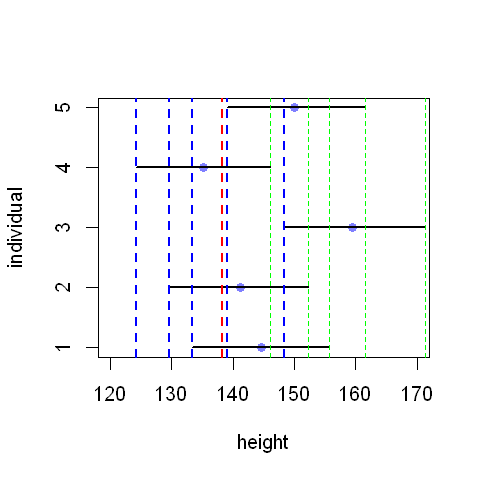

In [18]:
plot( individual ~ height , list(
    height = rev.z.score(apply( sim.height , 2 , mean, prob=0.89 )),
    individual = c(1,2,3,4,5)
) , col=col.alpha(rangi2,1), xlim=c(120,170),
     pch = 16 )
for ( i in 1:5 )
    lines(x=c(rev.z.score(apply( sim.height , 2 , PI,  prob=0.89 )[i+(i-1)]),
              rev.z.score(apply( sim.height , 2 , PI,  prob=0.89 )[i+i])),
          y=c(i,i), lwd = 2 )
# needed multiple for loops because didnt work otherwise.
for ( i in 1:5 )
    abline(v=rev.z.score(apply( sim.height , 2 , PI,  prob=0.89 )[i+(i-1)]),
           lty=2,
           col=c(ifelse((i+(i-1)) %% 2 ==0,'green','blue'),col.alpha(rangi2,0.5)),
           lwd=2)
for ( i in 1:5 )
    abline(v=rev.z.score(apply( sim.height , 2 , PI,  prob=0.89 )[i+i]),
           lty=2,
           col=ifelse((i+(i-1)) %% 2 ==0,'blue','green'),
           lwd=0)
abline(v = mean(d$height), col='red', lty=2, lwd=2)

In [19]:
mean(d$height)

[1] 138.2636

# Q2
- Model the relationship between height (cm) and the natural logarithm of
weight (log-kg):<p> log(weight).
- Use the entire Howell1 data frame, all 544 rows, adults and non-adults. 
- Use any model type from Chapter 4 that you think useful:
- an ordinary linear regression, a polynomial or a spline. 
- Plot the posterior predictions against the raw data.

In [20]:
d$log_weight <- log(d$weight)

In [21]:
# Standardize data
std.d2 <- data.frame(scale(d))

sd(d$age)
mean(d$age)

[1] 20.74689

[1] 29.34439

In [22]:
# data is at the individual level.
flist <- alist(
    height ~ dnorm( mu, sigma ),
    mu <- a + b1*weight ,
    a ~ dnorm(0,1),
    b1 ~ dlnorm(0,1),
    sigma ~ dlnorm(0,1)
)

model1 <- quap(flist = flist, data =list(height=std.d2$height,
                                         weight=std.d2$log_weight) )

In [23]:
model1


Quadratic approximate posterior distribution

Formula:
height ~ dnorm(mu, sigma)
mu <- a + b1 * weight
a ~ dnorm(0, 1)
b1 ~ dlnorm(0, 1)
sigma ~ dlnorm(0, 1)

Posterior means:
            a            b1         sigma 
-4.266322e-07  9.824483e-01  1.861441e-01 

Log-likelihood: 143.04 

In [24]:
attributes(scale(d))

$dim
[1] 544   5

$dimnames
$dimnames[[1]]
NULL

$dimnames[[2]]
[1] "height"     "weight"     "age"        "male"       "log_weight"


$`scaled:center`
     height      weight         age        male  log_weight 
138.2635963  35.6106176  29.3443934   0.4724265   3.4423298 

$`scaled:scale`
    height     weight        age       male log_weight 
27.6024476 14.7191782 20.7468882  0.4996986  0.5759596

In [25]:
z_score_log <- function(x) {(x - 3.44232984801386)/0.575959647001175}

In [26]:
z_score_log(log(d.pred$weight))

[1]  0.63256626  0.42806750  1.27102207 -0.01448477  0.91666503

In [27]:
inv_z_score_log <- function(x) {138.263596323529 + (x*27.6024476405647)}

In [28]:
# Uncertainty around parameter.
height.posterior <- link(fit = model1,data=list(weight=z_score_log(log(d.pred$weight))))
# Uncertainty around sampling,prediction
sim.height <- sim( model1 , data = list(weight=z_score_log(log(d.pred$weight))) )

In [29]:
inv_z_score_log(apply(sim.height, 2, PI, .89))

5%,147.6553,141.3181,164.6144,129.1462,154.9076
94%,163.7694,158.1312,180.9180,146.0172,171.2999


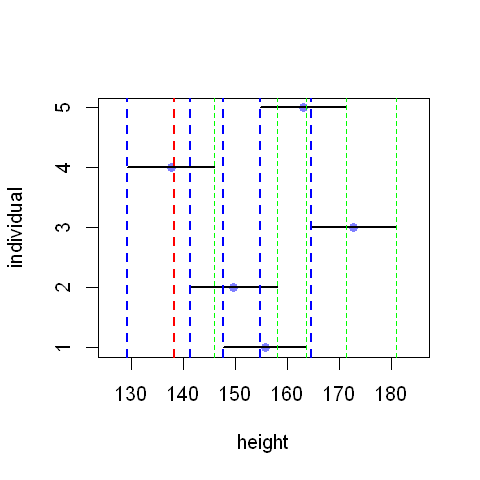

In [30]:
plot( individual ~ height , list(
    height = inv_z_score_log(apply( sim.height , 2 , mean, prob=0.89 )),
    individual = c(1,2,3,4,5)
) , col=col.alpha(rangi2,1), xlim=c(126,185),
     pch = 16 )
for ( i in 1:5 )
    lines(x=c(inv_z_score_log(apply( sim.height , 2 , PI,  prob=0.89 )[i+(i-1)]),
              inv_z_score_log(apply( sim.height , 2 , PI,  prob=0.89 )[i+i])),
          y=c(i,i), lwd = 2 )
# needed multiple for loops because didnt work otherwise.
for ( i in 1:5 )
    abline(v=inv_z_score_log(apply( sim.height , 2 , PI,  prob=0.89 )[i+(i-1)]),
           lty=2,
           col=c(ifelse((i+(i-1)) %% 2 ==0,'green','blue'),col.alpha(rangi2,0.5)),
           lwd=2)
for ( i in 1:5 )
    abline(v=inv_z_score_log(apply( sim.height , 2 , PI,  prob=0.89 )[i+i]),
           lty=2,
           col=ifelse((i+(i-1)) %% 2 ==0,'blue','green'),
           lwd=0)
abline(v = mean(d$height), col='red', lty=2, lwd=2)

In [31]:
seq.w <- seq(3, 64, 1)

sim.height_vs_data <- sim( model1 ,
                          data = list(weight=z_score_log(log(seq.w))))

mu.height <- link(model1 , data = list(weight=z_score_log(log(seq.w))))

mu <- inv_z_score_log(apply( mu.height , 2 , mean ))

mu.PI <- inv_z_score_log(apply( mu.height , 2 , PI, prob=0.89 ))

height.PI <- inv_z_score_log(apply( sim.height_vs_data , 2 , PI, prob=0.89 ))

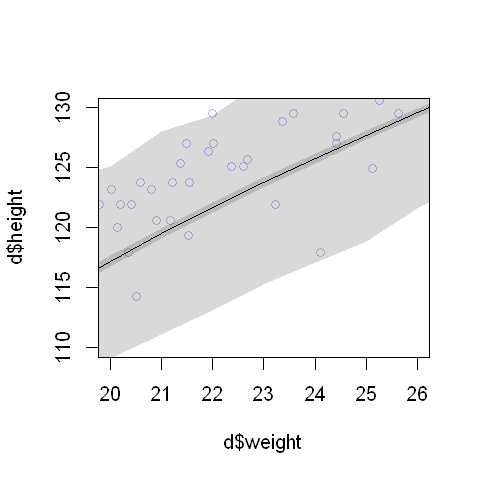

In [32]:
plot(d$height~d$weight,
     col=col.alpha(rangi2,0.5),
     xlim=range(20,26),
     ylim=range(110,130)
    )
lines(seq.w, mu )
shade(mu.PI, seq.w )
shade(height.PI, seq.w )

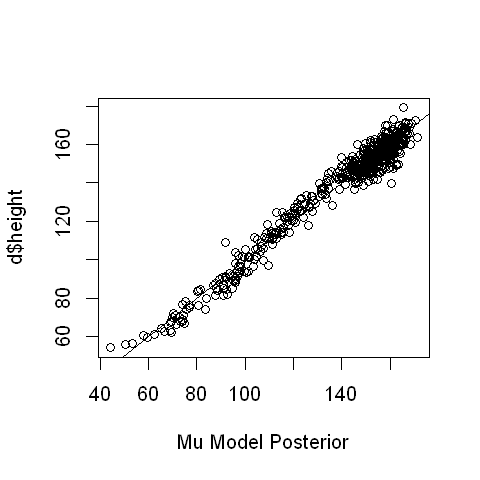

In [33]:
plot(d$height~inv_z_score_log(apply(link(model1) , 2 , mean )),
     xlab = 'Mu Model Posterior'
    )
abline(a = 0, b = 1 )

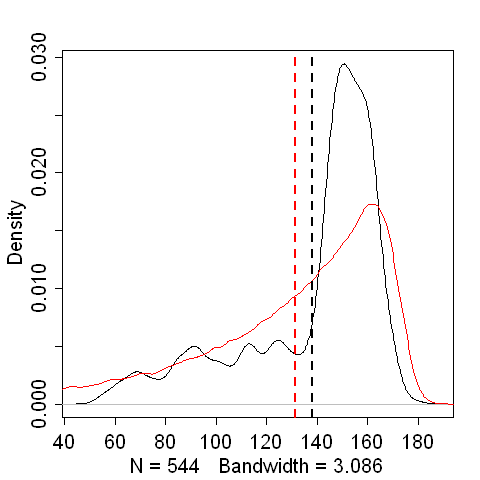

In [34]:
dens(d$height, col='black')
dens(inv_z_score_log(sim.height_vs_data), ylim=range(0,0.03), col='red', add = TRUE)
abline(v = mean(inv_z_score_log(sim.height_vs_data)), col='red', lty=2, lwd=2)
abline(v = mean(d$height), col='black', lty=2, lwd=2)

# Q3
- Plot the prior predictive distribution for the polynomial regression model in Chapter 4.  
Section 4.5.1 (pg.111)
- You can modify the code that plots the linear regression prior predictive distribution. 
- 20 or 30 parabolas from the prior should suffice to show where the prior probability resides.
- Can you modify the prior distributions of α, β1, and β2 so that the prior
predictions stay within the biologically reasonable outcome space?
- That is to say: Do not try to fit the data by hand.
- But do try to keep the curves consistent with what you know about height and weight,
before seeing these exact data.


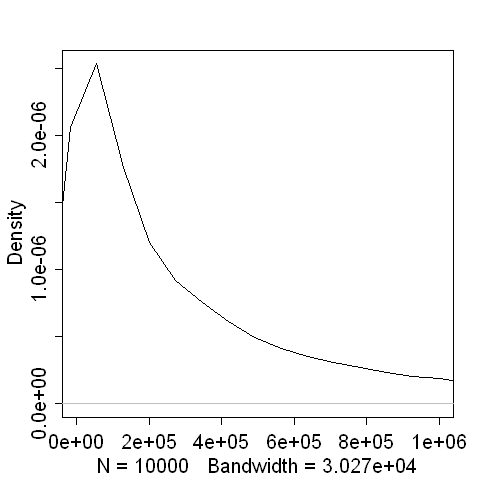

In [12]:
# h ~ Norm(mu, sig)
# mu <- alpha + beta1*x1 + beta2*x1^2
# alpha ~ Norm(178,20)
# beta1 ~ Log-Norm(0,1)
# beta2 ~ Log-Norm(0,1)
# sig ~ Unif(0,50)

# curve(dnorm(x , 178 , 20 ) , from=100 , to=250)
# curve(dunif(x,min = 2, max = 50), from=0 , to=60)
# curve(dlnorm(x,meanlog = 0, sdlog = 1), from=0 , to=2)

sig <- runif(n = 10000, min = 0, max = 10)
beta2 <- rlnorm(n = 10000, meanlog = 0, sdlog = 1)
beta1 <- rlnorm(n = 10000, meanlog = 0, sdlog = 1)
alpha <- rnorm(n = 10000, mean = 178, sd = 1)
x1 <- seq(to = 0, from = 1000, length.out = 10000)
mu <- alpha + beta1*x1 + beta2*x1^2
h <- rnorm(n = 10000, mean = mu , sd = sig)
#dens(h, xlim=range(0,1000000))
dens(mu, xlim=range(0,1000000))

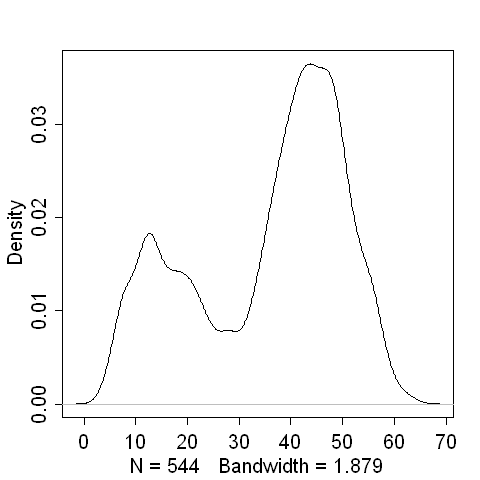

In [36]:
dens(d$weight)

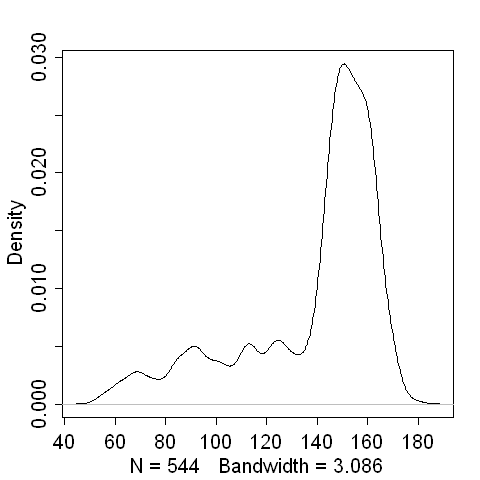

In [37]:
dens(d$height)

In [38]:
mean(mu)

[1] 554822.3

In [23]:
## R code 5.3
model.1 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + b1 * x + b2 * (x^2),
        a ~ dnorm( 178 , 1 ) ,
        b1 ~ dlnorm( 0 , 0.5 ) ,
        b2 ~ dlnorm( 0 , 0.5 ) ,
        sigma ~ dunif( 0, 0.005 )
    ) , data = list(x=x1, D=h ), start=list(x=178,D=178))

ERROR: Error in quap(alist(D ~ dnorm(mu, sigma), mu <- a + b1 * x + b2 * (x^2), : non-finite finite-difference value [6]
Start values for parameters may be too far from MAP.
Try better priors or use explicit start values.
If you sampled random start values, just trying again may work.
Start values used in this attempt:
x = 178
D = 178
a = 177.215090503859
b1 = 1.61901072140391
b2 = 0.842026000590819
sigma = 0.000314911988098174


In [9]:
model.1

ERROR: Error in eval(expr, envir, enclos): object 'model.1' not found


In [ ]:
## R code 5.4
set.seed(10)
prior <- extract.prior( m5.1 )
mu <- link( m5.1 , post=prior , data=list( A=c(-2,2) ) )
plot( NULL , xlim=c(-2,2) , ylim=c(-2,2) )
for ( i in 1:50 ) lines( c(-2,2) , mu[i,] , col=col.alpha("black",0.4) )

In [ ]:
# h ~ Norm(mu, sig)
# mu <- alpha + beta1*x1 + beta2*x1^2
# alpha ~ Norm(178,20)
# beta1 ~ Log-Norm(0,1)
# beta2 ~ Log-Norm(0,1)
# sig ~ Unif(0,50)